✅ Dataset loaded successfully!
Shape: (4424, 37)
Columns: ['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance\t', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemploy

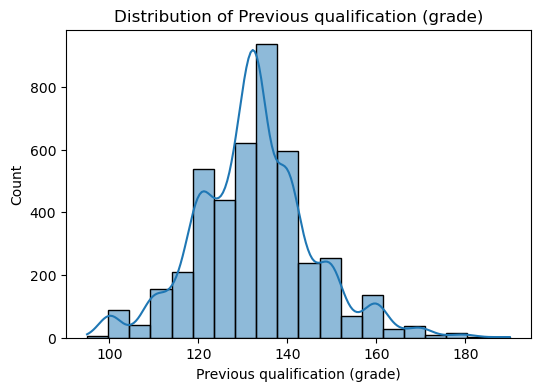

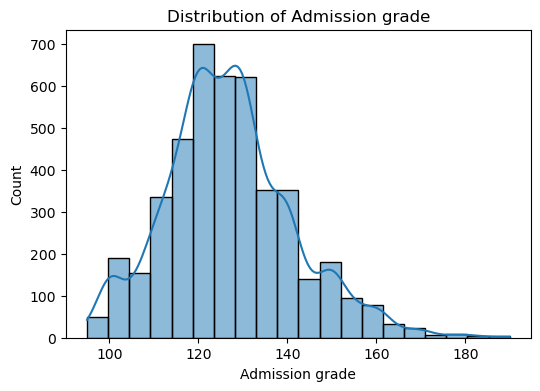

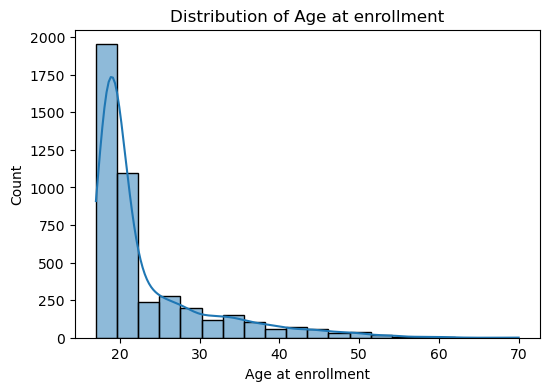

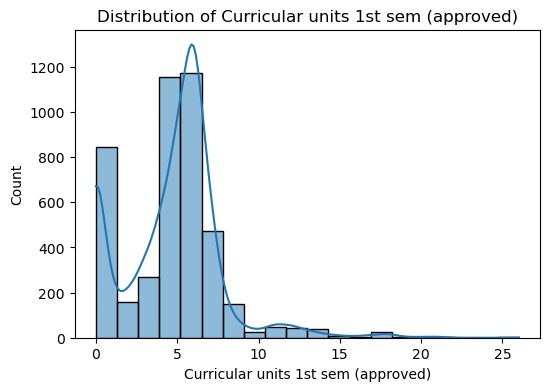

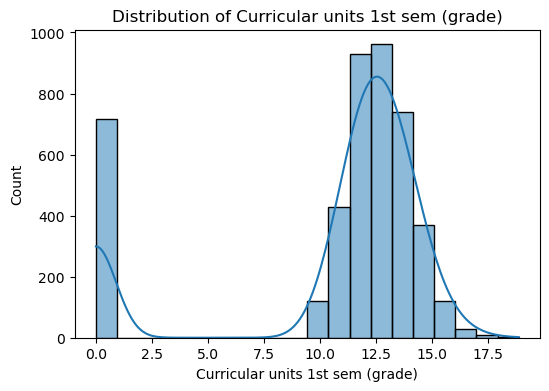

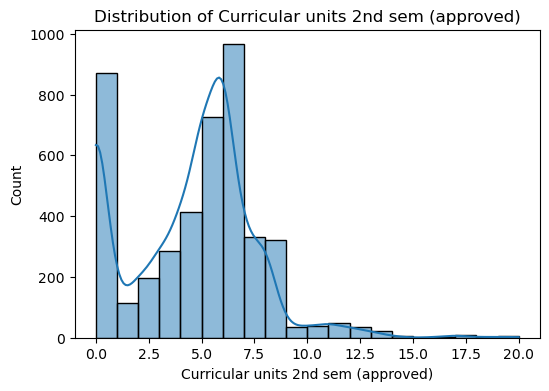

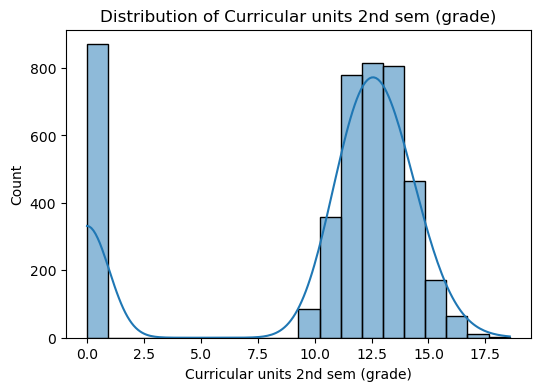

Previous qualification (grade): 179 outliers detected
Admission grade: 93 outliers detected
Age at enrollment: 523 outliers detected
Curricular units 1st sem (approved): 115 outliers detected
Curricular units 1st sem (grade): 532 outliers detected
Curricular units 2nd sem (approved): 156 outliers detected
Curricular units 2nd sem (grade): 5 outliers detected
✅ Outliers removed. New shape: (2821, 8)


ValueError: could not convert string to float: 'Graduate'

<Figure size 1000x600 with 0 Axes>

In [1]:
# ===========================================================
# Student Dropout Prediction - 
# ===========================================================

# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import pickle

# ===========================================================
# 2️⃣ Load Dataset
# ===========================================================
file_path = "data.csv"  
df = pd.read_csv(file_path, delimiter=';')

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# ===========================================================
# 3️⃣ Select Relevant Columns
# ===========================================================
columns_to_keep = [
    "Previous qualification (grade)",
    "Admission grade",
    "Age at enrollment",
    "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)",
    "Target"
]
df = df[columns_to_keep]
print("\n✅ Selected columns:")
print(df.columns.tolist())

# ===========================================================
# 4️⃣ Handle Missing Values
# ===========================================================
missing_values_count = df.isnull().sum()
print("\nMissing values per column:\n", missing_values_count)

# Drop rows with missing values (simple approach)
df = df.dropna()
print("✅ Missing values removed. New shape:", df.shape)

# ===========================================================
# 5️⃣ Descriptive Analysis
# ===========================================================
print("\nDescriptive statistics:\n", df.describe())

# Visualize distributions
num_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.show()

# ===========================================================
# 6️⃣ Outlier Detection & Handling
# ===========================================================
# Using IQR method
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} outliers detected")
    
    # Optionally remove outliers
    df = df[(df[col] >= lower) & (df[col] <= upper)]

print("✅ Outliers removed. New shape:", df.shape)

# ===========================================================
# 7️⃣ Statistical Analysis
# ===========================================================
# Correlation matrix
plt.figure(figsize=(10,6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# ===========================================================
# 8️⃣ Feature Engineering
# ===========================================================
df["Total_approved_units"] = (
    df["Curricular units 1st sem (approved)"] +
    df["Curricular units 2nd sem (approved)"]
)

df["Average_semester_grade"] = (
    (df["Curricular units 1st sem (grade)"] +
     df["Curricular units 2nd sem (grade)"]) / 2
)

df["Performance_index"] = df["Total_approved_units"] / (df["Average_semester_grade"] + 1)

df["Low_performance_flag"] = (
    (df["Average_semester_grade"] < 10) & 
    (df["Total_approved_units"] < 5)
).astype(int)

print("✅ Feature engineering completed.")

# ===========================================================
# 9️⃣ Prepare Features and Target
# ===========================================================
X = df.drop('Target', axis=1)
y = df['Target'].replace({"Dropout": 0, "Graduate": 1, "Enrolled": 1})

# ===========================================================
# 🔟 Train-Test Split
# ===========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\n✅ Data split completed!")
print("Training set:", X_train.shape)
print("Test set:", X_test.shape)

# ===========================================================
# 1️⃣1️⃣ Feature Scaling (Feature Tuning)
# ===========================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✅ Features scaled.")

# ===========================================================
# 1️⃣2️⃣ Handle Class Imbalance with SMOTE
# ===========================================================
print("\n📊 Class distribution before SMOTE:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print("📈 Class distribution after SMOTE:", Counter(y_train_resampled))

# ===========================================================
# 1️⃣3️⃣ Train CatBoost Classifier
# ===========================================================
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='Accuracy',
    verbose=100,
    random_state=42
)
model.fit(X_train_resampled, y_train_resampled, eval_set=(X_test_scaled, y_test), verbose=100)

# ===========================================================
# 1️⃣4️⃣ Evaluate Model
# ===========================================================
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n🎯 Model Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature importance
plt.figure(figsize=(8,5))
feature_importances = model.get_feature_importance()
sns.barplot(x=feature_importances, y=X.columns)
plt.title("Feature Importances")
plt.show()

# ===========================================================
# 1️⃣5️⃣ Save Model and Scaler
# ===========================================================
with open("best_catboost_model_final.pkl", "wb") as f:
    pickle.dump(model, f)
print("\n💾 Model and scaler saved successfully!")

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)